In [25]:
!pip install torch_summary

import os
import numpy as np
import pandas as pd
import cv2
import glob

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader, Dataset
from copy import deepcopy
from sklearn import cluster
from sklearn.model_selection import train_test_split

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as mticker
%matplotlib inline

print(torch.__version__)

print("Imported all libraries successfully!")

2.4.0
Imported all libraries successfully!


In [26]:
# checking if GPU is working as expected or not
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
!nvidia-smi

cuda
Fri Oct 18 11:57:28 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P0             29W /   70W |     359MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+

In [27]:
# fetching dataset
!git clone https://github.com/udacity/P1_Facial_Keypoints.git

fatal: destination path 'P1_Facial_Keypoints' already exists and is not an empty directory.


In [28]:
root_dir = "/kaggle/working/P1_Facial_Keypoints/data/training/"
csv_path = "/kaggle/working/P1_Facial_Keypoints/data/training_frames_keypoints.csv"
all_img_paths = glob.glob(os.path.join(root_dir, "*.jpg"))

In [29]:
data = pd.read_csv(csv_path)
data.head()
# even columns represents the x coordinate 
# odd columns represents the y coordinate

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [30]:
# img_path = root_dir+data.iloc[0, 0]
# print(img_path)

In [31]:
class FacesData(Dataset):
    
    def __init__(self, df):
        super(FacesData).__init__()
        self.df = df
        # setting up mean and standard deviation according to vgg model
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        img_path = root_dir+self.df.iloc[idx, 0]
        img = cv2.imread(img_path)/255
        kp = deepcopy(self.df.iloc[idx, 1:].tolist())
        kp_x = (np.array(kp[0::2])/img.shape[1]).tolist()
        kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()
        kp2 = kp_x+kp_y
        kp2 = torch.tensor(kp2)
        img = self.preprocess_input(img)
        return img, kp2
        
    def preprocess_input(self, img):
        img = cv2.resize(img, (224, 224))
        img = torch.tensor(img).permute(2, 0, 1)
        img = self.normalize(img).float()
        return img.to(device)
        
    def load_img(self, idx):
        img_path = root_dir + self.df.iloc[idx, 0]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255
        img = cv2.resize(img, (224, 224))
        return img

In [32]:
train, test = train_test_split(data, test_size = 0.2, random_state = 42)
train_dataset = FacesData(train.reset_index(drop=True))
test_dataset = FacesData(test.reset_index(drop=True))

train_loader = DataLoader(train_dataset, batch_size = 32)
test_loader = DataLoader(test_dataset, batch_size = 32)

In [33]:
def get_model():
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.Sequential(nn.Conv2d(512, 512, 3),
                                 nn.MaxPool2d(2),
                                 nn.Flatten())
    model.classifier = nn.Sequential(nn.Linear(2048, 512),
                                    nn.ReLU(),
                                    nn.Dropout(0.5),
                                    nn.Linear(512, 136),
                                    nn.Sigmoid())
    loss_fn = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    return model.to(device), loss_fn, optimizer

In [34]:
model, loss_fn, optimizer = get_model()
# print(model)
print(summary(model, (3, 224, 224)))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

In [35]:
def train_batch(img, kps, model, optimizer, loss_fn):
    model.train()
    optimizer.zero_grad()
    _kps = model(img.to(device))
    loss = loss_fn(_kps, kps.to(device))
    loss.backward()
    optimizer.step()
    return loss

def validate_batch(img, kps, model, loss_fn):
    model.eval()
    _kps = model(img.to(device))
    loss = loss_fn(_kps, kps.to(device))
    return _kps, loss

In [36]:
train_loss, test_loss = [], []

n_epochs = 50

for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    epoch_train_loss, epoch_test_loss = 0, 0
    
    for idx, (img, kps) in enumerate(train_loader):
        loss = train_batch(img, kps, model, optimizer, loss_fn)
        epoch_train_loss += loss.item()
    epoch_train_loss /= (idx+1)

    for idx, (img, kps) in enumerate(test_loader):
        ps, loss = validate_batch(img, kps, model, loss_fn)
        epoch_test_loss += loss.item()
    epoch_test_loss /= (idx+1)

    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50


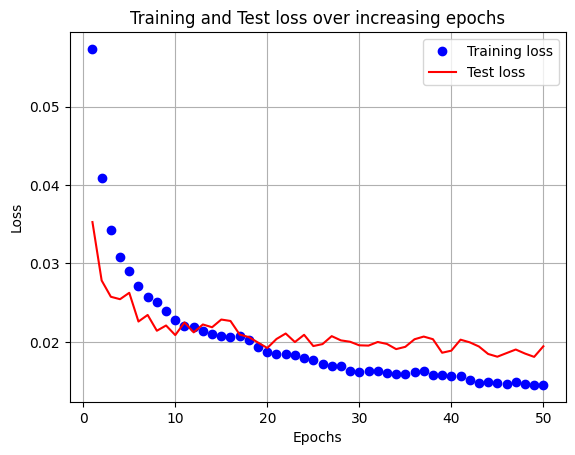

In [37]:
epochs = np.arange(50)+1
plt.plot(epochs, train_loss, "bo", label="Training loss")
plt.plot(epochs, test_loss, "r", label="Test loss")
plt.title("Training and Test loss over increasing epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid("off")
plt.show()

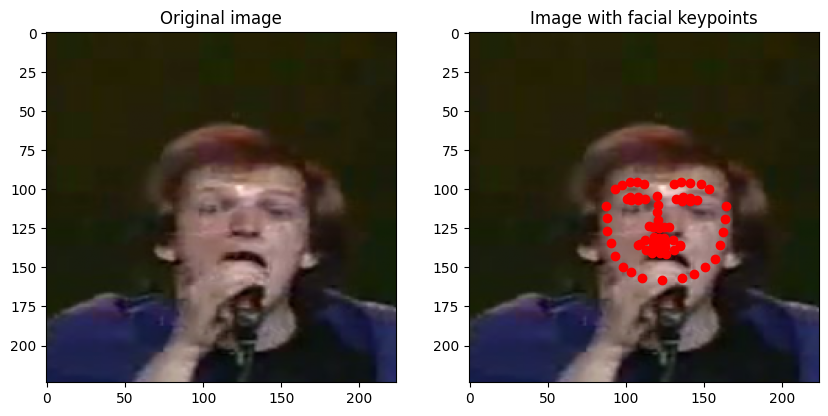

In [38]:
idx = 0
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title("Original image")
img = test_dataset.load_img(idx)
plt.imshow(img)
plt.grid(False)
plt.subplot(222)
plt.title("Image with facial keypoints")
x, _ = test_dataset[idx]
plt.imshow(img)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c="r")
plt.grid(False)
plt.show()